# [GDCV]6th_Project-OCR
***
## 1. 학습 데이터  
## 2. 인식 모델 설계
## 3. Keras-OCR
## 4. 결과 확인
***

## 1. 학습 데이터

      먼저 Recognition Model의 학습을 진행하기위해 MJ Synth를 사용해보도록 하겠습니다. 압축파일에 포함된 데이터 중에서 MJ 데이터만 활용할 예정입니다.

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/home/aiffel-dj39/aiffel/ocr


      Text recognition 모델을 직접 만들어보도록 하겠습니다. Recognition 모델은 2015년에 발표된 아래 논문에서 처음 소개된 CRNN 구조를 활용해서 만들어보도록 합시다.

In [2]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

# 로컬 사용자
TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/home/aiffel-dj39/aiffel/ocr/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


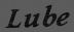

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


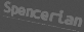

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


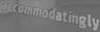

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


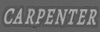

In [3]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

## 2. 인식 모델 설계

      mdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현하려고 합니다. dataset_path는 읽어들일 데이터셋의 경로입니다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 합니다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

In [4]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

      Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다. 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 

In [5]:
class LabelConverter(object):
     # Convert between text-label and text-index 

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

The total number of characters is 36
Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)


    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

      데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다. 우리는 시간이 많지 않으니 적절한 Epoch를 설정하여 모델을 학습시켜봅시다! 1Epoch에 10초 정도 소요될 것입니다.

In [9]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
model.fit(train_set, steps_per_epoch=len(val_set), epochs=100, validation_data=val_set, validation_steps=len(val_set), callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 29.4274
Epoch 00001: val_loss improved from inf to 27.16313, saving model to /home/aiffel-dj39/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 10s 157ms/step - loss: 29.4274 - val_loss: 27.1631
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 26.6029
Epoch 00002: val_loss improved from 27.16313 to 26.91236, saving model to /home/aiffel-dj39/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 9s 138ms/step - loss: 26.6029 - val_loss: 26.9124
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 26.0492
Epoch 00003: val_loss did not improve from 26.91236
63/63 [==============================] - 8s 128ms/step - loss: 26.0492 - val_loss: 27.0011
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 25.6806
Epoch 00004: val_loss improved from 26.91236 to 26.44717, saving model to /home/aiffel-dj39/aiffel/ocr/model_checkpoint.h

      학습 결과를 시각화 하고 확인해봅니다.

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Result: 	 SLINKING9999999999999999


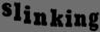

Result: 	 ALEPPO99999999999999999


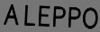

Result: 	 IWENDA999999999999999999


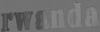

Result: 	 NATHANS99999999999999999


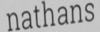

Result: 	 HALLO999999999999999999


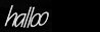

Result: 	 HURLS9999999999999999999


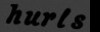

Result: 	 DOWNSIZE9999999999999999


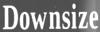

Result: 	 ROBOTIC99999999999999999


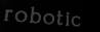

Result: 	 SLOPPY99999999999999999


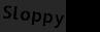

Result: 	 HERMITE99999999999999999


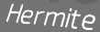

In [10]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'


model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## 3. Keras-OCR

      이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 작성합니다. 그리고나서 잘라낸 이미지를 시각화하고 영역을 확인합니다.

In [11]:
import keras_ocr
from keras_ocr.detection import Detector
SAMPLE_IMG_PATH = '/home/aiffel-dj39/aiffel/ocr/sample.jpg'

detector = Detector()


Looking for /home/aiffel-dj39/.keras-ocr/craft_mlt_25k.h5


In [12]:
def detect_text(img_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    
    images = keras_ocr.tools.read(img_path)
    predictions = pipeline.recognize([img_path])
    
    result_img = keras_ocr.tools.drawAnnotations(image=images, predictions=predictions[0])

    cropped_imgs = []
    revised_boxes = []
    for _, box in predictions[0]:
        revised_boxes.append(box)
    boxes = revised_boxes

    crop_box =[]
    for box in boxes:
        cropped_imgs.append(keras_ocr.tools.warpBox(image=images, box=box))


    return result_img, cropped_imgs

Looking for /home/aiffel-dj39/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel-dj39/.keras-ocr/crnn_kurapan.h5


/home/aiffel-dj39/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

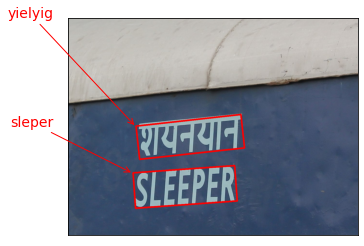

In [13]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

(-0.5, 420.5, 145.5, -0.5)

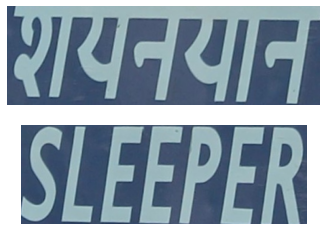

In [14]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

## 4. 결과 확인

In [15]:
import cv2

def recognize_img(pil_img, input_img_size=(100,32)):
    img90 = cv2.rotate(pil_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_flip = cv2.flip(img90, 0)
    pil_img = cv2.resize(img_flip, (32, 100), interpolation = cv2.INTER_CUBIC)
    img = pil_img.reshape(1, 100, 32, 3)
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 YGRUIET99999999999999999


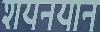

Result: 	 SLEEPER9999999999999999


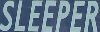

In [16]:
for _img in cropped_img:
    recognize_img(_img)

      위의 언어는 제대로 인식하는데 실패했지만 아래의 SLEEPER는 성공적으로 인식하였다.
      이는 학습용 데이터가 대부분 영어로 이루어져서 그런 것 같다.

***
# 총평 및 결론

      전에 진행했던 18번째 익스플로레이션을 참고하여 진행하였다. (https://github.com/kanaria142/first-repository/blob/master/(E18)18th_Project-OCR.ipynb)
      
      단어의 영역은 제대로 인식이 진행되었으나 이후 학습한 모델로 단어를 추론할 때, 영어는 제대로 읽었으나 외국어는 비슷하게 생긴 알파벳으로 대체되었다. 